In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
import matplotlib.pyplot as plt
import matplotlib as mpl


In [3]:
mpl.rcParams['figure.figsize'] = (20, 6)  # Width, Height in inches

In [4]:
file_name = "PGMs_Prices_V3.xlsx"
cols = ['Date', 'Portfolio_Return', 'Portfolio_Value']

df = pd.read_excel(file_name)

df['Date'] = pd.to_datetime(df['Date'])
# Convert timestamps to Unix timestamps (seconds since epoch)
df['UnixTs'] = df['Date'].astype('int64') // 10**9  # Convert nanoseconds to seconds


In [5]:
# also create moving average line

# Calculate the moving average
# df['5DayMA'] = df['Portfolio_Value'].rolling(window=sequence_length).mean()
# df['10DayMA'] = df['Portfolio_Value'].rolling(window=sequence_length * 2).mean()
# df['30DayMA'] = df['Portfolio_Value'].rolling(window=sequence_length * 6).mean()

In [6]:
# normalize data
# df.drop(columns=['Date'], inplace=True)
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns

normalized_data = (df[numeric_columns] - df[numeric_columns].mean()) / df[numeric_columns].std()


In [74]:
# Windowing: Creating sequences/windows
sequence_length = 5  # which is the rolling window dates
sequences = []
for i in range(len(normalized_data) - sequence_length):
    sequences.append(normalized_data[i:i+sequence_length])
sequences = np.array(sequences)

Text(0.5, 1.0, 'Original Data with Moving Average')

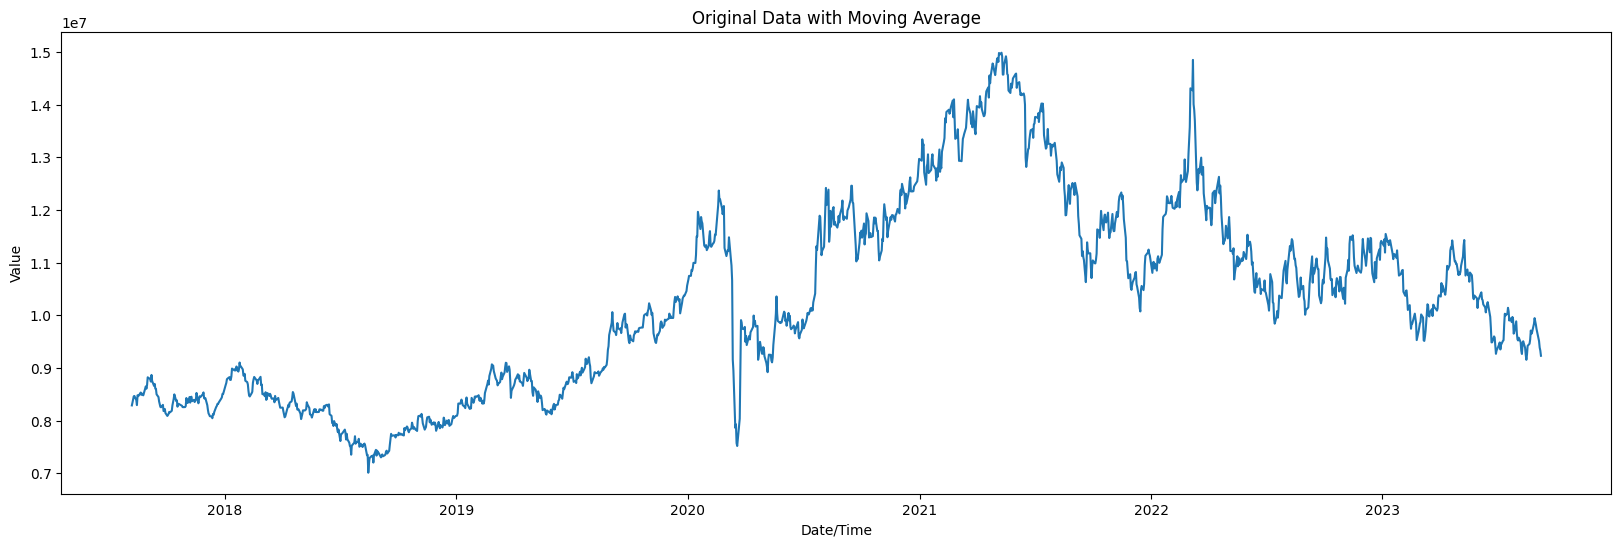

In [56]:
plt.plot(df['Date'], df['Portfolio_Value'], label='Original Data')

# Plot the moving average line
# plt.plot(df['Date'], df['5DayMA'], label='5D MA', lw=0.5, color='cyan')
# plt.plot(df['Date'], df['10DayMA'], label='10D MA', lw=0.5, color='magenta')
# plt.plot(df['Date'], df['30DayMA'], label='30D MA',lw=0.5, color='black')


# Customize labels and title
plt.xlabel('Date/Time')
plt.ylabel('Value')
plt.title('Original Data with Moving Average')

In [69]:
# Split data into train and validation sets
train_size = int(0.8 * len(sequences))
train_data = sequences[:train_size]
val_data = sequences[train_size:]

In [61]:
# Define the autoencoder model
num_features = 33 # ?? 

model = Sequential([
    LSTM(64, activation='relu', input_shape=(sequence_length, num_features), return_sequences=True),
    LSTM(32, activation='relu', return_sequences=False),
    RepeatVector(sequence_length),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(num_features))
])

In [62]:
model.compile(optimizer='adam', loss='mse')

# Training the autoencoder
model.fit(train_data, train_data, epochs=100, batch_size=32, validation_data=(val_data, val_data))


Epoch 1/100


39/39 [==============================] - 5s 24ms/step - loss: 0.9031 - val_loss: 0.6181
Epoch 2/100
39/39 [==============================] - 0s 8ms/step - loss: 0.5820 - val_loss: 0.3732
Epoch 3/100
39/39 [==============================] - 0s 8ms/step - loss: 0.4548 - val_loss: 0.3661
Epoch 4/100
39/39 [==============================] - 0s 9ms/step - loss: 0.4020 - val_loss: 0.2915
Epoch 5/100
39/39 [==============================] - 0s 8ms/step - loss: 0.3794 - val_loss: 0.2768
Epoch 6/100
39/39 [==============================] - 0s 9ms/step - loss: 0.3687 - val_loss: 0.2567
Epoch 7/100
39/39 [==============================] - 0s 9ms/step - loss: 0.3786 - val_loss: 0.2707
Epoch 8/100
39/39 [==============================] - 0s 8ms/step - loss: 0.3431 - val_loss: 0.2542
Epoch 9/100
39/39 [==============================] - 0s 8ms/step - loss: 0.3264 - val_loss: 0.2443
Epoch 10/100
39/39 [==============================] - 0s 9ms/step - loss: 0.3214 - val_loss: 0.2374
Epoch 11/100
39/39 [

In [63]:
# Reconstruction of validation data
predicted_val_data = model.predict(val_data)

# Calculating reconstruction loss
reconstruction_losses = np.mean(np.square(val_data - predicted_val_data), axis=(1, 2))

# Define a threshold for detecting regime changes
# Calculate mean and standard deviation of reconstruction errors on validation set
error_mean = np.mean(reconstruction_losses)
error_std = np.std(reconstruction_losses)

# Set threshold as a multiple of standard deviation above the mean error
#threshold = error_mean + 2 * error_std  # Adjust the multiplier as needed
threshold = error_mean - error_std/2

print(f"error_mean {error_mean}\nerror_std {error_std}\nthreshold {threshold}")

# Detect regime changes based on the threshold for validation dataset
regime_change_indices_val = np.where(reconstruction_losses > threshold)[0]
regime_change_indices_val

# Calculate reconstruction errors for training data
predicted_train_data = model.predict(train_data)
reconstruction_errors_train = np.mean(np.square(train_data - predicted_train_data),  axis=(1, 2))
regime_change_indices_train = np.where(reconstruction_errors_train > threshold)[0]

all_regime_change_indices = np.concatenate((regime_change_indices_train, regime_change_indices_val))

regime_change_indices_train

error_mean 0.10900519657379365
error_std 0.05588331566380944
threshold 0.08106353874188893


array([  59,   60,   61,   62,   63,   80,   81,   86,   94,  105,  118,
        119,  120,  121,  131,  141,  142,  146,  147,  148,  149,  150,
        154,  155,  156,  157,  158,  167,  168,  169,  170,  171,  172,
        173,  174,  175,  182,  183,  184,  186,  193,  194,  201,  202,
        207,  208,  209,  211,  212,  218,  219,  222,  223,  224,  226,
        230,  231,  232,  233,  239,  240,  241,  242,  243,  244,  245,
        246,  247,  249,  268,  270,  271,  272,  273,  276,  277,  280,
        283,  289,  308,  309,  312,  317,  318,  326,  327,  330,  331,
        332,  333,  334,  335,  336,  337,  340,  341,  342,  343,  344,
        345,  348,  359,  360,  361,  362,  363,  364,  368,  369,  370,
        371,  372,  373,  374,  375,  376,  378,  379,  380,  381,  382,
        383,  384,  385,  386,  387,  388,  391,  392,  405,  407,  414,
        415,  416,  418,  442,  443,  444,  458,  470,  471,  472,  473,
        474,  477,  478,  479,  480,  481,  482,  4

In [79]:
predict_portfolio = np.concatenate([predicted_train_data, predicted_val_data], axis=0)
# s = np.append(predict_portfolio, np.full(sequence_length, predict_portfolio[-1]))
# df_pred = df.assign(New_Column=s)

# Get the shape of the NumPy array
num_rows, temp, num_cols = predict_portfolio.shape

# Generate column names based on array dimensions
column_names = [f'Column_{i}' for i in range(num_cols)]

# Convert NumPy array to DataFrame with matching columns
df = pd.DataFrame(predict_portfolio, columns=column_names)


ValueError: Must pass 2-d input. shape=(1528, 5, 33)

In [25]:
# group change points
from sklearn.cluster import DBSCAN
# Reshape the data for DBSCAN (needed for sklearn)
X = all_regime_change_indices.reshape(-1, 1)

# DBSCAN parameters 
epsilon = sequence_length * 2 # Maximum distance between points to be considered in the same neighborhood
min_samples = sequence_length * 2  # Minimum number of samples in a neighborhood

In [26]:
# DBSCAN clustering
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(X)

# Getting cluster labels and core sample indices
cluster_labels = dbscan.labels_
core_samples_mask = np.zeros_like(cluster_labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

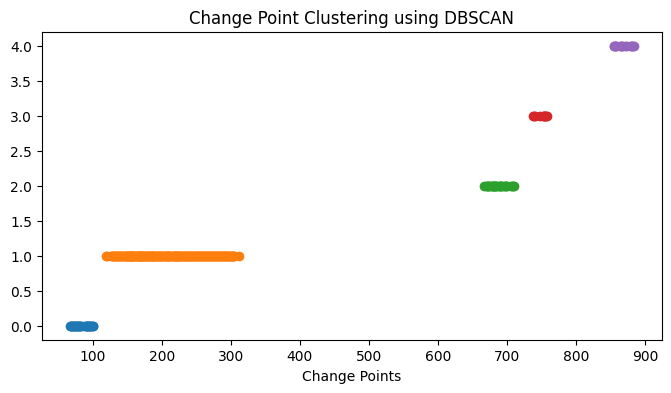

In [32]:
# Extracting unique clusters and their indices
unique_labels = set(cluster_labels)
if -1 in unique_labels:
    unique_labels.remove(-1)  # Remove noise label (-1)

    # Plotting clustered change points
plt.figure(figsize=(8, 4))

for label in unique_labels:
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_points = all_regime_change_indices[cluster_indices]
    plt.plot(cluster_points, np.ones_like(cluster_points) * label, 'o', label=f'Cluster {label}')

plt.xlabel('Change Points')
plt.title('Change Point Clustering using DBSCAN')
# plt.legend()
plt.show()

NameError: name 'df_pred' is not defined

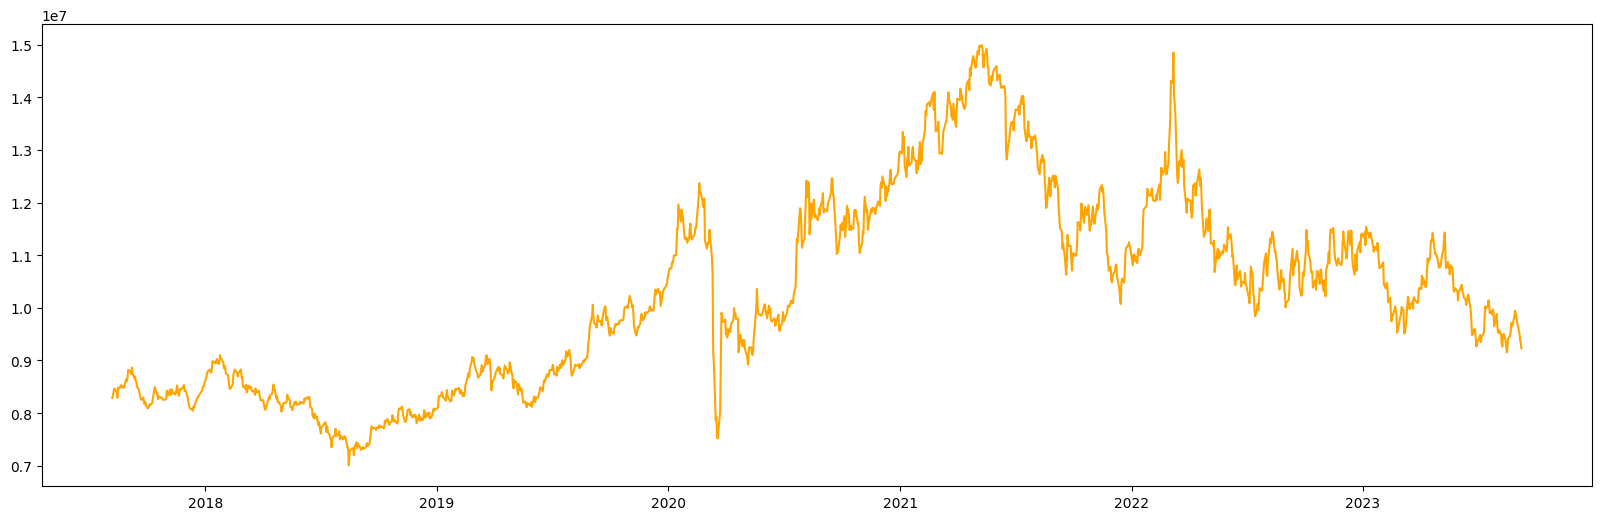

In [41]:
# Plot the data and change points
plt.plot(df['Date'], df['Portfolio_Value'], label='Portfolio_Value', color="orange")
#plt.scatter(df['Date'], [df['Volatility'][i] for i in change_points], color='red', marker='o', label='Change Points')
plt.plot(df['Date'], df_pred['Value_Pred'], label='Portfolio_Value_Pred', color="gray")


# Mark the change points on the chart
for change_point in all_regime_change_indices:
    plt.scatter(df['Date'][change_point], df['Portfolio_Value'][change_point], marker='o', color='red', zorder=3)

for label in unique_labels:
    label_indices = np.where(cluster_labels == label)[0]
    # cluster_points = all_regime_change_indices[label_indices]
    start_index = label_indices[0]
    end_index = label_indices[-1]
    
    plt.fill_between(df['Date'][start_index:end_index+2], df['Portfolio_Value'][start_index:end_index+2], alpha=0.6, label=f'Cluster {label}')

plt.xlabel("Time")
plt.ylabel("Portfolio Value")
plt.title('AutoEncoder Change Point Detection')
plt.legend()
plt.show()

print("Change points detected at indices:", all_regime_change_indices)

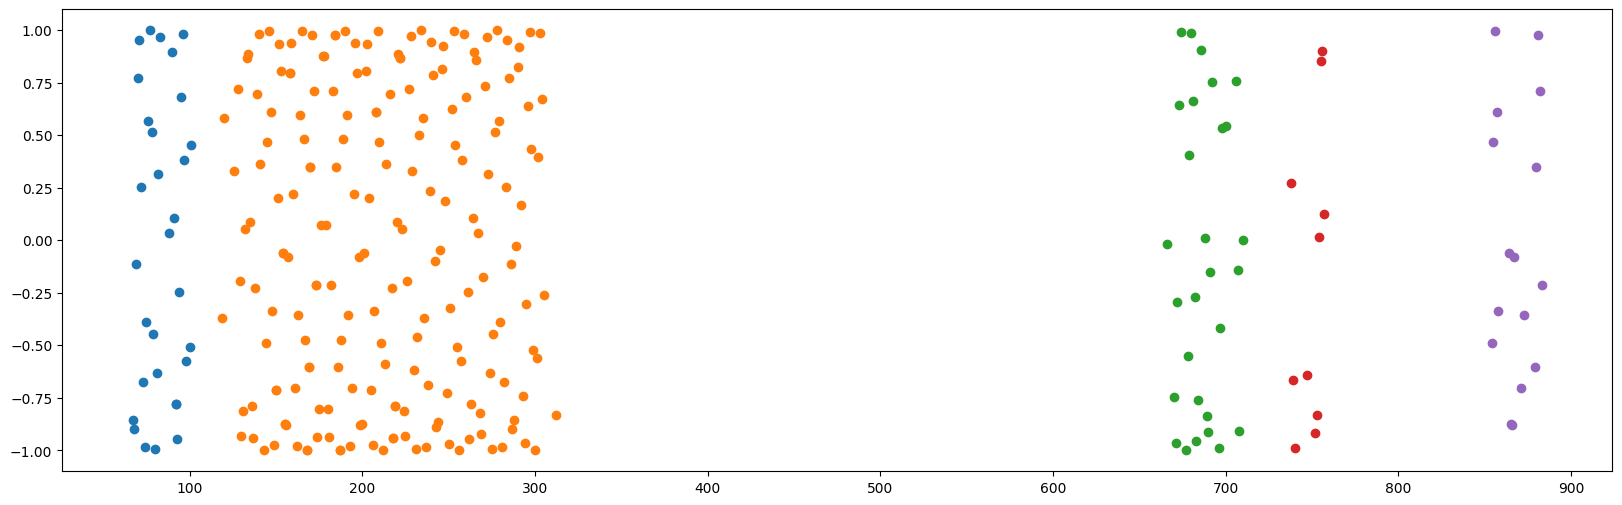

In [29]:
# Overlaying clustered change points on the original chart
for label in unique_labels:
    cluster_indices = np.where(cluster_labels == label)[0]
    cluster_points = all_regime_change_indices[cluster_indices]
    plt.plot(cluster_points, np.sin(cluster_points), 'o', label=f'Cluster {label}')


In [17]:
# with change points, define regimes
from sklearn.cluster import KMeans

# Assuming data is your entire dataset and regimes represent the identified change points
# Perform clustering on the data around change points to define regimes
#df.drop(columns=['Date'], axis=1, inplace=True)
cluster_model = KMeans(n_clusters=3)  # Define the number of regimes
cluster_labels = cluster_model.fit_predict(df.iloc[all_regime_change_indices])

cluster_labels

# regimes = []

# for i, label in enumerate(cluster_labels):
#     regime_window = df.iloc[all_regime_change_indices[i]:all_regime_change_indices[i+1]]
#     regimes.append({
#         'Regime': f'Regime_{label}',
#         'Data': regime_window
#     })


TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [184]:
regimes = []

# Assuming 'data' is your DataFrame and 'all_regime_change_indices' contains change points
for i in range(len(all_regime_change_indices)):
    start_index = all_regime_change_indices[i]
    if i == len(all_regime_change_indices) - 1:
        end_index = len(df) - 1  # Use the last index of the data as the end index for the last regime
    else:
        end_index = all_regime_change_indices[i + 1]
    
    regime_window = df.iloc[start_index:end_index]
    regimes.append({
        'Regime': f'Regime_{i + 1}',
        'Start_Index': start_index,
        'End_Index': end_index,
        'Data': regime_window
    })

#regimes

In [185]:
# add back date column for plotting
df['Date'] = pd.to_datetime(df['UnixTs'], unit='s') 

Text(0.5, 1.0, 'Original Data with Regime Overlay')

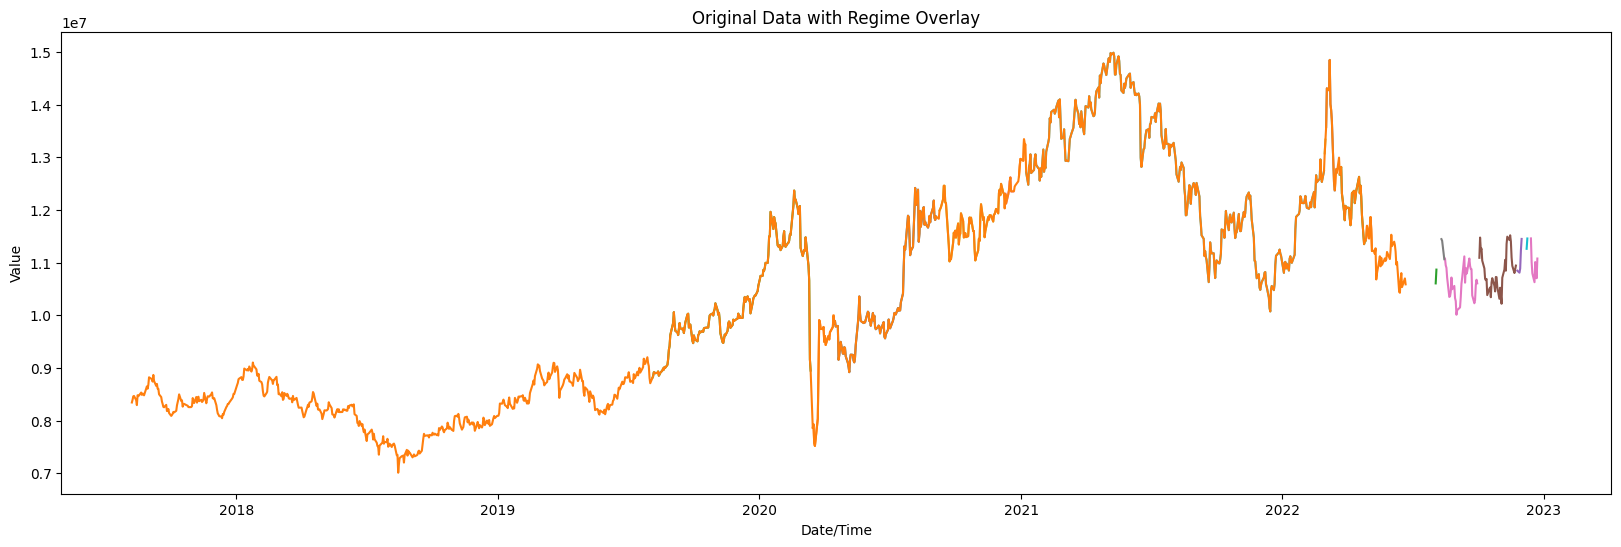

In [186]:
# Overlay regimes on the chart
for regime in regimes:
    start_index = regime['Start_Index']
    end_index = regime['End_Index']
    regime_data = df.iloc[start_index:end_index]
    
    plt.plot(regime_data['Date'], regime_data['Portfolio_Value'])

# Customize labels and title
plt.xlabel('Date/Time')
plt.ylabel('Value')
plt.title('Original Data with Regime Overlay')

# Show legend
# plt.legend()


In [ ]:
# plot the moving average



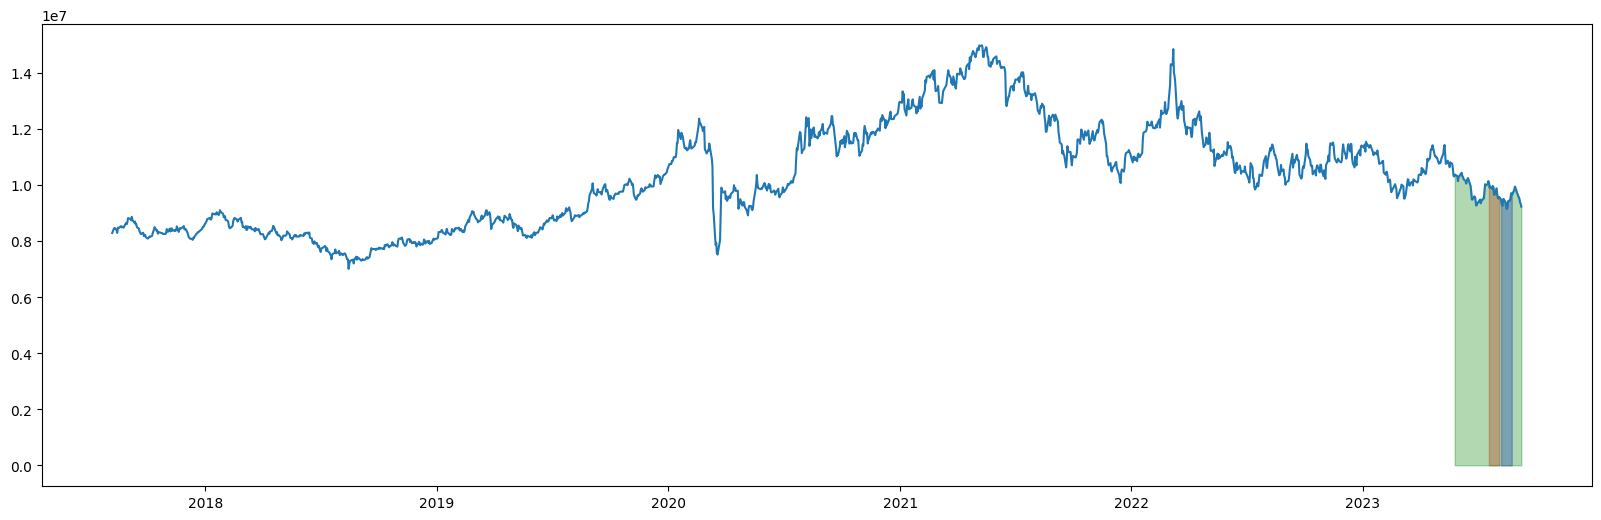

In [187]:
# Define colors for each label
colors = {0: 'red', 1: 'blue', 2: 'green'}  # Add more colors if needed
# Plot the entire time series data
plt.plot(df['Date'], df['Portfolio_Value'], label='Original Data')

# Highlight regions based on labels
for label in range(3): 
    label_indices = np.where(cluster_labels == label)[0]
    if len(label_indices) > 0:
        start_index = label_indices[0]
        end_index = label_indices[-1]
        plt.fill_between(df['Date'].iloc[start_index:end_index + 1],
                         df['Portfolio_Value'].iloc[start_index:end_index + 1],
                         color=colors[label], alpha=0.3, label=f'Label {label}')
